There are a few bugs in the code of https://discourse.julialang.org/t/solving-difference-equation-part-2/67057.

* The code `for k in 2:length(x)` in the function `seqper_new(x; tol=1e-3)` must be corrected as `for k in 2:(length(x) ÷ 2 + 1)`.
* `nxblock * (ii - 1) + jj` must be `nyblock * (ii - 1) + jj`.
* `(i - 1) * xpts + j` must be `(i - 1) * ypts + j`
* The `Threads.@threads for` loop of the function `isoperiodic_test` is not thread-safe, so that the result changes with each execution.  Threads are conflicting at the line `set_parameter!(ds, [par1range[i], par2range[j]])`, where the same `ds` will be modified by multiple threads.

Memory allocations are also unnecessarily too much.

* The size of the array `sol_last` in memory is (NIter + 1) * xpts * ypts * 8 bytes = 2001 * 100 * 100 * 8 bytes = 153 MB, which is quite large, but it is discarded at the end of the function `isoperiodic_test`.
* Each execution of the `DynamicalSystems.trajectory` function results in a wasted memory allocation, which is repeated tens of thousands of times.

Other points that need improvement

* The calculation results are saved to a file, and the results cannot be reused without going through the file.
* The code is unnecessarily complicated.
* You have created the complicated function `isoperiodic_test` to do most of all the work you want to do.

Furthermore, it is not necessary to use `DynamicalSystems.jl` in this case.

__My test implementation:__

In [1]:
using Base.Threads
using Plots
pyplot() # https://github.com/JuliaPlots/Plots.jl/issues/3560
using CSV
using DataFrames

function f(x, p)
   r, k = p
   a, mu, d = 5.0, 0.5, 0.2
   xnew1 = x[1]*exp(r*(1-x[1]/k)-x[2]/(a+x[1]^2))
   xnew2 = x[2]*exp(mu*x[1]/(a+x[1]^2)-d)
   xnew1, xnew2
end

function traj2d!(tr1, tr2, f, p, x0, niters, nwarmup)
    x = x0
    for _ in 1:nwarmup
        x = f(x, p)
    end
    @inbounds tr1[1], tr2[1] = x
    for i in 2:niters+1
        x = f(x, p)
        @inbounds tr1[i], tr2[i] = x
    end
end

function findperiod(x; tol=1e-3)
    n = length(x)
    @inbounds for k in 2:(n ÷ 2 + 1)
        if abs(x[k] - x[1]) ≤ tol
            all(j -> abs(x[j] - x[j-k+1]) ≤ tol, k:n) && return k - 1
        end
    end 
    return n
end

function calcperiod2d(f = f, niters = 2000, nwarmup = 50000, x0 = (0.4, 0.5),
        r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3
    )
    tmp1 = [Vector{Float64}(undef, niters+1) for _ in 1:nthreads()]
    tmp2 = [Vector{Float64}(undef, niters+1) for _ in 1:nthreads()]
    period = Matrix{Int}(undef, length(r), length(k))
    @threads for j in eachindex(k)
        tid = threadid()
        tr1, tr2 = tmp1[tid], tmp2[tid]
        for i in eachindex(r)
            p = (r[i], k[j])
            traj2d!(tr1, tr2, f, p, x0, niters, nwarmup)
            @inbounds period[i, j] = findperiod(tr1; tol)
        end
    end
    period, r, k
end

xm1ox(x) = (x - 1)/x # x minus 1 over x : {x ≥　1} -> {0 ≤ y < 1}
inv1my(y) = 1/(1 - y) # inverse of 1 minus 1 : {0 ≤ y < 1} -> {x ≥ 1}

function plot_period(r, k, period; kwargs...)
    cbtick = [1, 2, 3, 4, 5, 6, 10, 30]
    colorbar_ticks = (xm1ox.(cbtick), string.(cbtick))
    heatmap(r, k, xm1ox.(period)'; xlabel="r", ylabel="k", title="period",
        colorbar_ticks, kwargs...)
end

function save_period(r, k, period; fn = "result.csv")
    ii, jj = reim(complex.(axes(r, 1), axes(k, 1)'))
    rr, kk = reim(complex.(r, k'))
    df = DataFrame(i = vec(ii), j = vec(jj), r = vec(rr), k = vec(kk), period = vec(period))
    CSV.write(fn, df)
end

function load_period(fn = "result.txt")
    df = CSV.read(fn, DataFrame)
    imax = maximum(df.i)
    jmax = maximum(df.j)
    r = reshape(df.r, imax, jmax)[1:imax]
    k = reshape(df.k, imax, jmax)[1:imax:end]
    period = reshape(df.period, imax, jmax)
    period, r, k
end

load_period (generic function with 2 methods)

In [2]:
using Logging
disable_logging(Logging.Warn)

LogLevel(1001)

  3.109461 seconds (517.41 k allocations: 33.035 MiB, 7.54% compilation time)
  2.870107 seconds (228 allocations: 433.594 KiB)
  2.909849 seconds (221 allocations: 433.531 KiB)


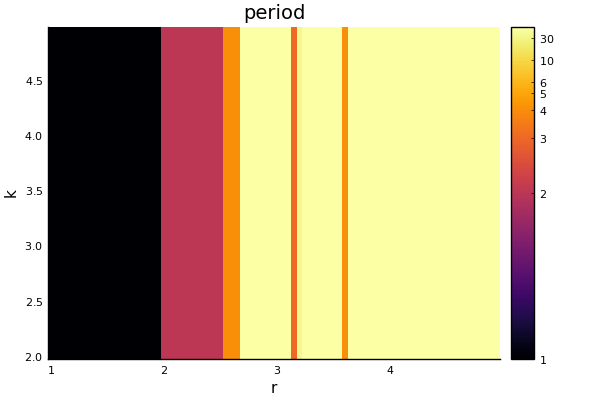

In [3]:
period, r, k = @time calcperiod2d()
period, r, k = @time calcperiod2d()
period, r, k = @time calcperiod2d()
plot_period(r, k, period)

In [4]:
period, r, k = calcperiod2d()
fn = save_period(r, k, period; fn = "result.csv")
df = CSV.read(fn, DataFrame)

,i,j,r,k,period
,Int64,Int64,Float64,Float64,Int64
1,1,1,1.0,2.0,1
2,2,1,1.05,2.0,1
3,3,1,1.1,2.0,1
4,4,1,1.15,2.0,1
5,5,1,1.2,2.0,1
6,6,1,1.25,2.0,1
7,7,1,1.3,2.0,1
8,8,1,1.35,2.0,1
9,9,1,1.4,2.0,1


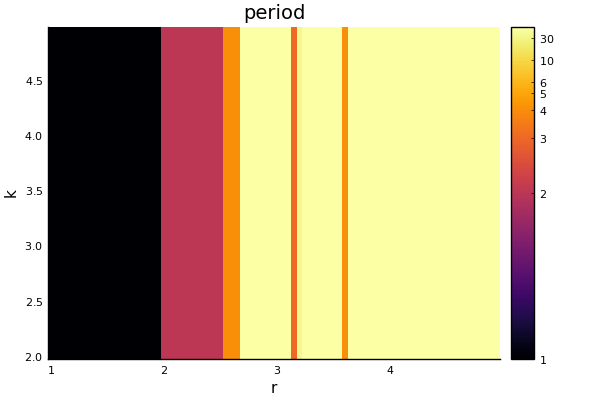

In [5]:
period, r, k = load_period(fn)
plot_period(r, k, period)

  6.311571 seconds (904 allocations: 518.463 KiB, 0.07% compilation time)
  6.340179 seconds (253 allocations: 474.734 KiB)
  6.341094 seconds (251 allocations: 474.641 KiB)


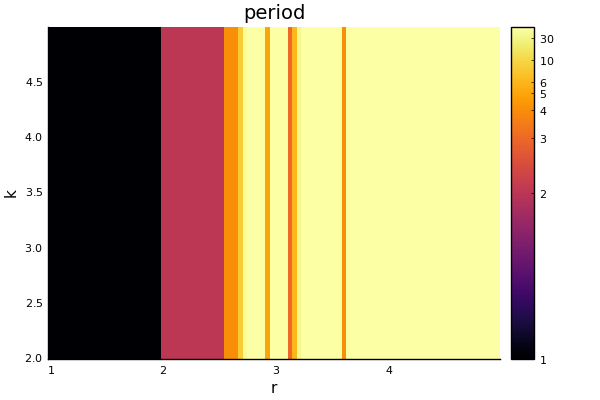

In [6]:
niters = 2000
nwarmup = 50000
x0 = (0.4, 0.5)
r = range(1, 5, length=100+1)[1:end-1]
k = range(2, 5, length=100+1)[1:end-1]
period, = @time calcperiod2d(f, niters, nwarmup, x0, r, k)
period, = @time calcperiod2d(f, niters, nwarmup, x0, r, k)
period, = @time calcperiod2d(f, niters, nwarmup, x0, r, k)
plot_period(r, k, period)

 25.035733 seconds (225 allocations: 701.062 KiB)
 24.258212 seconds (331 allocations: 710.266 KiB)
 24.257828 seconds (331 allocations: 710.266 KiB)


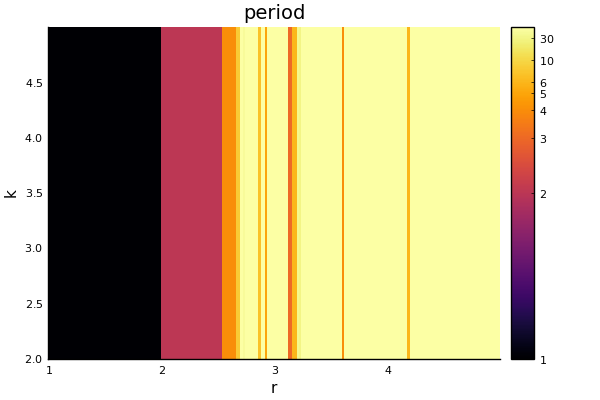

In [7]:
niters = 2000
nwarmup = 50000
x0 = (0.4, 0.5)
r = range(1, 5, length=200+1)[1:end-1]
k = range(2, 5, length=200+1)[1:end-1]
period, = @time calcperiod2d(f, niters, nwarmup, x0, r, k)
period, = @time calcperiod2d(f, niters, nwarmup, x0, r, k)
period, = @time calcperiod2d(f, niters, nwarmup, x0, r, k)
plot_period(r, k, period)